Using TensorFlow backend.


Epoch 1/4
12624/12624 [==============================] - 36s - loss: 0.0352 - val_loss: 0.0324
Epoch 2/4
12624/12624 [==============================] - 32s - loss: 0.0319 - val_loss: 0.0296
Epoch 3/4
12624/12624 [==============================] - 32s - loss: 0.0312 - val_loss: 0.0304
Epoch 4/4
12624/12624 [==============================] - 32s - loss: 0.0309 - val_loss: 0.0292
dict_keys(['loss', 'val_loss'])


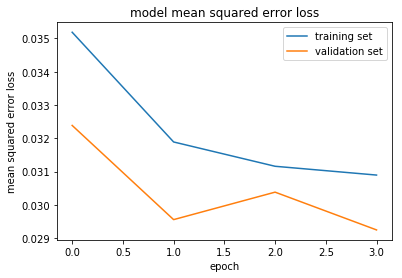

In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
%matplotlib inline

samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        samples.append(row)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)


CORRECTION = 0.2
                
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for batch_sample in batch_samples:
                # Use 3 cameras
                measurement = float(batch_sample[3])
                measurement_left = measurement + CORRECTION
                measurement_right = measurement - CORRECTION
                
                for i in range(3):
                    name = './data/IMG/'+batch_sample[0].split('\\')[-1]
                    center_image = cv2.imread(name)
                    center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
#                     measurements = float(batch_sample[3])
                    images.append(center_image)
#                     angles.append(center_angle)

                    #flipping
                    images.append(cv2.flip(center_image,1))
#                     measurements.append(center_angle*-0.1)
                    
                measurements.extend([measurement,
                     measurement*-1,
                     measurement_left,
                     measurement_left*-1,
                     measurement_right,
                     measurement_right*-1])

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D,Convolution2D,Dropout
from keras.layers import MaxPooling2D

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

# ch, row, col = 3, 80, 320  # Trimmed image format

model = Sequential()
model.add(Lambda(lambda x: x /255.0 - 0.5,input_shape=(160, 320,3)))
model.add(Cropping2D(cropping=((60,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2, 2), activation = 'relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(36,5,5,subsample=(2,2), activation = 'relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(48,5,5,subsample=(2,2), activation = 'relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(64,3,3,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(64,3,3,activation = 'relu'))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dense(1))



model.compile(loss = 'mse', optimizer = 'adam')

# model.fit(X_train,y_train,validation_split=0.2,shuffle=True,nb_epoch=1)

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples)*6, validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=4, verbose=1)

"""
If the above code throw exceptions, try 
model.fit_generator(train_generator, steps_per_epoch= len(train_samples),
validation_data=validation_generator, validation_steps=len(validation_samples), epochs=5, verbose = 1)
"""


### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')

In [2]:
import keras
print (keras.__version__)  

1.2.1
